<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/inside-deep-learing/02-fully-connected-networks/01_neural_networks_as_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Neural networks as optimization

If we make the input to the loss function a neural network, we can use this exact same approach to train a neural network. This creates a process called a training loop with three major components: 
* the training data (with correct answers), 
* the model and loss function, 
* the update via gradients

<img src='https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/inside-deep-learing/02-fully-connected-networks/images/1.png?raw=1' width='600'/>

Our model needs parameters to adjust. Changing the parameters allows the network to alter its predictions to try to reduce the loss function.

Now we have all we need to abstractly describe learning as a function minimization problem.

##Setup

In [ ]:
from tqdm.autonotebook import tqdm

import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import pandas as pd

import time

In [ ]:
!wget https://github.com/EdwardRaff/Inside-Deep-Learning/raw/main/idlmam.py

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import * 
from idlmam import *

In [4]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

torch.backends.cudnn.deterministic=True
set_seed(42)

In [5]:
def move_to(obj, device):
  """
  obj: the python object to move to a device, or to move its contents to a device
  device: the compute device to move objects to
  """
  if hasattr(obj, "to"):
      return obj.to(device)
  elif isinstance(obj, list):
      return [move_to(x, device) for x in obj]
  elif isinstance(obj, tuple):
      return tuple(move_to(list(obj), device))
  elif isinstance(obj, set):
      return set(move_to(list(obj), device))
  elif isinstance(obj, dict):
      to_ret = dict()
      for key, value in obj.items():
          to_ret[move_to(key, device)] = move_to(value, device)
      return to_ret
  else:
      return obj

##Defining dataset

Here we’ve created a synthetic regression problem with linear and nonlinear components,
with some noise added to make it interesting.

In [6]:
# Creates one-dimensional input
X = np.linspace(0, 20, num=200)
y = X + np.sin(X) * 2 + np.random.normal(size=X.shape)
print(X.shape)
print(y.shape)
print(X[1])
print(y[1])

(200,)
(200,)
0.10050251256281408
0.16290502361958653


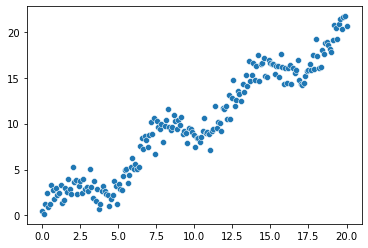

In [7]:
sns.scatterplot(x=X, y=y)

But we need the problem in a form that PyTorch will understand.

So we have to creates a simple dataset object that knows we have a one-dimensional problem.

In [8]:
class Simple1DRegressionDataset(Dataset):

  def __init__(self, X, y):
    super(Simple1DRegressionDataset, self).__init__()
    # The leftover dimension is denoted with –1
    self.X = X.reshape(-1, 1)
    self.y = y.reshape(-1, 1)

  def __getitem__(self, index):
    inputs = torch.tensor(self.X[index, :], dtype=torch.float32)
    targets = torch.tensor(self.y[index], dtype=torch.float32)
    return (inputs, targets)

  def __len__(self):
    return self.X.shape[0]

Along with the Dataset, we also need a DataLoader. 

Whereas the
Dataset defines how to get any specific data point, the
DataLoader decides which data points to get.

In [9]:
training_loader = DataLoader(Simple1DRegressionDataset(X, y), shuffle=True)

##The training loop

In [10]:
def train_network(model, loss_func, data_loader, epochs=20, device="cpu"):
  # create the SGD optimizer
  optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

  # Place the model on the correct compute resource (CPU or GPU)
  model.to(device)

  # iterating through all the data (batches) multiple times (epochs)
  for epoch in tqdm(range(epochs), desc="Epoch"):
    # Put the model in training mode
    model = model.train()
    running_loss = 0.0

    # iterating through all the inputs (features) and labels (target)
    for inputs, labels in tqdm(data_loader, desc="Batch", leave=False):
      # Move the batch of data to the device we are using
      inputs = move_to(inputs, device)
      labels = move_to(labels, device)

      #PyTorch stores gradients in a mutable data structure. So we need to set it to a clean state before we use it. 
      #Otherwise, it will have old information from a previous iteration
      optimizer.zero_grad()

      # perform the prediction
      y_hat = model(inputs)

      # Compute loss
      loss = loss_func(y_hat, labels)

      # compute the gradient
      loss.backward()

      # Now we just need to update all the parameters
      optimizer.step()

      # just grabbing some information we would like to have
      running_loss += loss.item()

##Training model

In [11]:
in_features = 1
out_features = 1

model = nn.Linear(in_features, out_features)
loss_func = nn.MSELoss()

train_network(model, loss_func, training_loader)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/200 [00:00<?, ?it/s]

In [13]:
# just plot our model’s prediction for all the data
with torch.no_grad():
  y_pred = model(torch.tensor(X.reshape(-1, 1), device="cpu", dtype=torch.float32)).cpu().numpy()

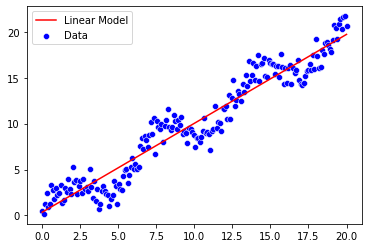

In [14]:
sns.scatterplot(x=X, y=y, color="blue", label="Data")
sns.lineplot(x=X, y=y_pred.ravel(), color="red", label="Linear Model")